In [1]:
from dask.distributed import Client

client = Client(n_workers=6)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 181.98 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40873,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 181.98 GiB
Comm: tcp://127.0.0.1:36883,Total threads: 2
Dashboard: http://127.0.0.1:38533/status,Memory: 30.33 GiB
Nanny: tcp://127.0.0.1:44027,


In [1]:
import os 
import xarray as xr
from utils.xarray_functions import add_time, compute_radiance
from utils.xarray_functions import compute_ndvi
from utils.function_clns import config
import zarr
import dask.array as da

In [2]:
from vegetation.preprocessing.ndvi_prep import XarrayWS
from dask.diagnostics import ProgressBar
from vegetation.preprocessing.ndvi_prep import apply_seviri_cloudmask

### SEVIRI loading and cloud masking
chunks = {"time":-1, "lat":"auto", "lon":"auto"}
filename = "ndvi_full_image.zarr"
ds_ndvi_915 = xr.open_zarr(os.path.join(config["NDVI"]["ndvi_path"],filename), chunks=chunks)

def preprocess(ds):
    ds = add_time(ds)
    return ds

# path1 = "/media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/09_30"
# files = [os.path.join(path1, file) for file in os.listdir(path1) if file.endswith(".nc")][:4]
# ds_cloud930 = xr.open_mfdataset(files, preprocess=preprocess)

path2 = "/media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/09_15"
files = [os.path.join(path2, file) for file in os.listdir(path2) if file.endswith(".nc")]
ds_cloud915 = xr.open_mfdataset(files, preprocess=preprocess, engine='netcdf4', parallel=False)

ds = apply_seviri_cloudmask(ds_ndvi_915, ds_cloud915)
# ds_chunked = ds.chunk(chunks={"time":-1, "lat":90, "lon":90})

/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/abc.py:106: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 156
  result = blockwise(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 156
  result = blockwise(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 156
  result = blockwise(


In [1]:
### Whittaker smoothing pipeline

ws_ds = XarrayWS(ds_chunked)

with ProgressBar():
    ds_clean = ws_ds.apply_ws2doptvp(variable="ndvi", p=0.99, lambda_max=4)

compressor = zarr.Blosc(cname="zstd", clevel=4, shuffle=2)
# encodings
enc = {x: {"compressor": compressor} for x in ds_clean}

filename = "seviri_full_image_smoothed.zarr"
# encoding = {'zlib': True, "complevel":4}
# compression = {"ndvi" :encoding, "channel_1":encoding, "channel_2": encoding}
from utils.function_clns import config
from dask.diagnostics import ProgressBar

with ProgressBar():
    ds_clean.to_zarr(os.path.join(config["NDVI"]["ndvi_path"], filename),
             encoding=enc, mode="w")

In [2]:
from vegetation.preprocessing.ndvi_prep import remove_ndvi_outliers

chunks={"time":-1, "lat":90, "lon":90}
filename = "seviri_full_image_smoothed.zarr"
ds_clean = xr.open_zarr(os.path.join(config["NDVI"]["ndvi_path"], filename), 
                        chunks=chunks)

/media/BIFROST/N2/Riccardo/Indices_analysis/src/vegetation/preprocessing/ndvi_prep.py:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif plot is "Basemap":
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/abc.py:106: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [3]:
### Selecting places with many errors

mask_error = xr.where((ds_clean["ndvi"]<-1)|(ds_clean["ndvi"]>1),1,0)
mask_err = (mask_error.sum(["time"])/mask_error.count(["time"]))

# Define your condition
condition = mask_err > 0.10

# Use boolean indexing to filter lat and lon combinations that meet the condition
lat_lon_combinations = ds_clean.where(condition.compute(), drop=True)

# Access the lat and lon values of the filtered combinations
filtered_lat = lat_lon_combinations['lat'].values
filtered_lon = lat_lon_combinations['lon'].values

import numpy as np
lat_indices, lon_indices = np.where(condition)

ds_clean["ndvi"] = remove_ndvi_outliers(ds_clean["ndvi"])

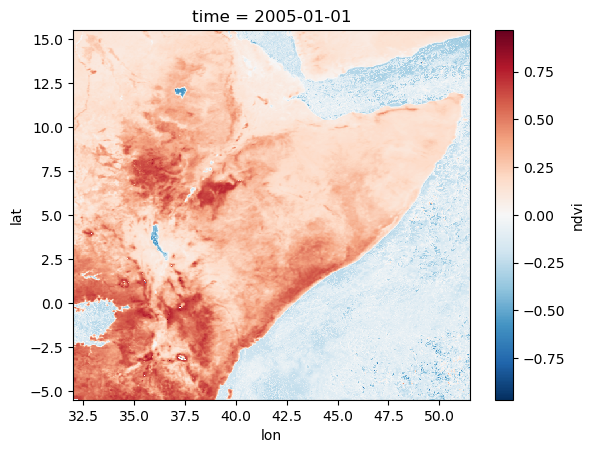

In [4]:
ds_clean["ndvi"].where(mask_err<0.1).isel(time=0).plot()

In [12]:
streaks_data

<xarray.DataArray 'ndvi' (lat: 644, lon: 598, time: 6805)> Size: 10GB
dask.array<transpose, shape=(644, 598, 6805), dtype=float32, chunksize=(80, 80, 6805), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 5kB -5.484 -5.451 -5.418 -5.386 ... 15.42 15.45 15.48
  * lon      (lon) float64 5kB 32.02 32.05 32.08 32.11 ... 51.42 51.45 51.48
Dimensions without coordinates: time

In [ ]:
def find_streaks(arr):
    streaks = np.zeros_like(arr)  # Create an array of zeros with the same shape as input
    quality_flag =  np.zeros_like(arr) 
    current_streak = 0
    for i, value in enumerate(arr):
        if np.isnan(value):
            current_streak += 1
            streaks[i] = np.NaN
            quality_flag[i] = np.NaN
        else:
            if current_streak > 0:
                streaks[i] = current_streak
                quality_flag[i - current_streak:i] = current_streak
                current_streak = 0
    if current_streak > 0:
        print(current_streak)
        streaks[i] = current_streak
        quality_flag[-current_streak:] = current_streak
    return streaks

def quality_flag(arr):
    streaks = np.zeros_like(arr)  # Create an array of zeros with the same shape as input
    current_streak = 0
    for i, value in enumerate(arr):
        if np.isnan(value):
            current_streak += 1
            streaks[i] = np.NaN
        else:
            if current_streak > 0:
                streaks[i - current_streak:i] = current_streak
                current_streak = 0
    if current_streak > 0:
        streaks[-current_streak:] = current_streak
    return streaks

arr = np.array([0.5, np.NaN, 0.5, np.NaN, np.NaN, 0.3, 0.33, 0.34, np.NaN, np.NaN])

In [34]:
find_streaks(arr)

2


array([ 0., nan,  1., nan, nan,  2.,  0.,  0., nan,  2.])

In [35]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.distributed import progress

# # Step 1: Find NaN streaks for each pixel
# def find_streaks(arr):
#     streaks = []
#     current_streak = 0
#     for value in arr:
#         if np.isnan(value):
#             current_streak += 1
#             streaks.append(np.NaN)
#         else:
#             if current_streak > 0:
#                 streaks.append(current_streak)
#                 current_streak = 0
#             else:
#                 streaks.append(np.NaN)
#     if current_streak > 0:
#         streaks.append(current_streak)
#     else:
#         streaks.append(np.NaN)
#     return np.array(streaks)

def find_streaks(arr):
    streaks = np.zeros_like(arr)  # Create an array of zeros with the same shape as input
    quality_flag =  np.zeros_like(arr) 
    current_streak = 0
    for i, value in enumerate(arr):
        if np.isnan(value):
            current_streak += 1
            streaks[i] = np.NaN
            quality_flag[i] = np.NaN
        else:
            if current_streak > 0:
                streaks[i] = current_streak
                quality_flag[i - current_streak:i] = current_streak
                current_streak = 0
    if current_streak > 0:
        streaks[i] = current_streak
        quality_flag[-current_streak:] = current_streak
    return streaks, quality_flag


# Apply find_streaks along the time dimension with dask.delayed
streaks_data, quality_flag = xr.apply_ufunc(
    find_streaks,
    ds["ndvi"].chunk({'time': -1, "lat":80, "lon":80}),
    input_core_dims=[['time']],
    output_core_dims=[['time'], ["time"]],
    # exclude_dims={"time"},
    vectorize=True,
    dask='parallelized',
    # dask_gufunc_kwargs={"output_sizes": {"time": len(ds["time"])}},
    output_dtypes=[np.float32,np.float32], 
)

# Step 2: Calculate length of each streak
total_length = streaks_data.sum(dim='time')
num_streaks = streaks_data.count(dim='time')

# Step 3: Calculate average
average_length = total_length / num_streaks

filename = "mask_num_streaks.zarr"

with ProgressBar():
    average_length.to_zarr(os.path.join(config["NDVI"]["ndvi_path"], 
                                                         filename), mode="w")

[######################                  ] | 57% Completed | 113m 10s

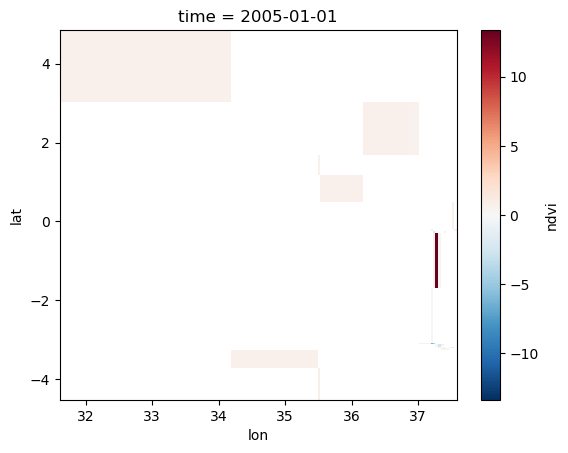

In [11]:
lat_lon_combinations.ndvi.isel(time=0).plot()

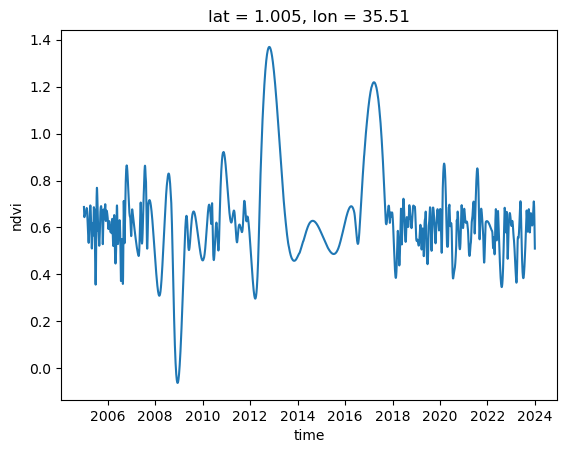

In [3]:
ds_clean.ndvi.sel(lat=1, lon =35.5, method="nearest").plot()

In [6]:
from modape.whittaker import ws2doptv, ws2d, ws2doptvp
from array import array
import numpy as np

y = ds.ndvi.sel(lat=1, lon =35.5, method="nearest")
print("Selected")
y_corr = xr.where(y.isnull(), 0, y) #np.where(np.isnan(y), 0, y) 
w = xr.where(y.isnull(), 0, 1) #np.where(np.isnan(y), 0, 1)

p = 0.99 
lambda_min=-2
lambda_max = 4

w_corr = w.to_numpy().astype(np.double)
y_corr_db = y_corr.to_numpy().astype(np.double)

print("calculating WS")

z, sopt = ws2doptvp(y_corr_db, w_corr, 
                    array("d", np.arange(lambda_min, lambda_max, 0.2).round(2)), 
                    p=p)
z_arr =  np.array(z, dtype=np.float32)

Selected


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 11.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 11.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


calculatin WS


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 11.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


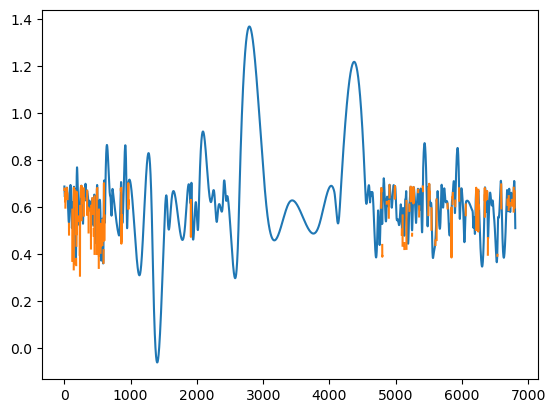

In [7]:
import matplotlib.pyplot as plt
plt.plot(z_arr)
plt.plot(y)

### Cleaning NDVI due to clouds

In [4]:
import zarr

compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
# encodings
enc = {x: {"compressor": compressor} for x in ds}

filename = "ndvi_full_image.zarr"
# encoding = {'zlib': True, "complevel":4}
# compression = {"ndvi" :encoding, "channel_1":encoding, "channel_2": encoding}
from utils.function_clns import config
from dask.diagnostics import ProgressBar

with ProgressBar():
    ndvi.to_zarr(os.path.join(config["NDVI"]["ndvi_path"], filename),
             encoding=enc)

[                                        ] | 0% Completed | 333.62 ss

IOStream.flush timed out


[########################################] | 100% Completed | 6hr 42m


In [ ]:
from vegetation.preprocessing.ndvi_clean import XarrayWS

ws = XarrayWS(on_disk.chunk({"time":-1, "lat":50, "lon":50}))
data = ws.apply_ws2doptvp("ndvi", p=0.99, lambda_max=4)

In [5]:
mean_ndvi = on_disk["ndvi"].mean(["lat","lon"])

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_ndvi.plot()

In [ ]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


In [ ]:
from vegetation.data_collection.ee_modis import EeModis
from utils.function_clns import config


start_date = "2018-08-17"
end_date = "2023-12-31"

modis_data = EeModis(start_date, end_date, name="ref_061")

In [2]:
ds = modis_data.xarray_preprocess()
from utils.function_clns import subsetting_pipeline, prepare
ds = subsetting_pipeline(prepare(ds))

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


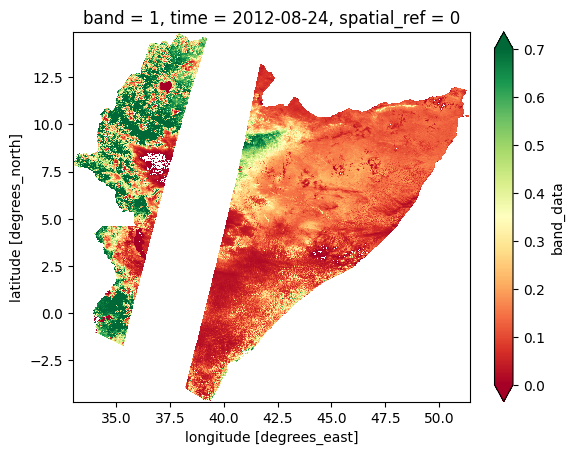

In [16]:
ds.band_data.isel(time=4).plot(vmin=0, vmax = 0.7, cmap="RdYlGn")

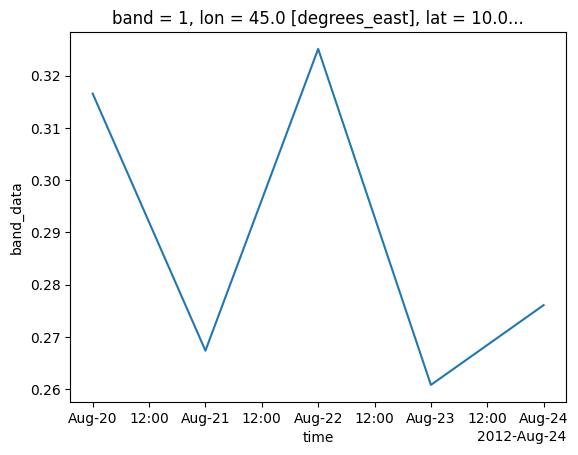

In [22]:
lat = 10
lon = 45

ds.band_data.sel(lat=lat, lon=lon, method="nearest").plot()